# Import

In [1]:
import csv
import os
import pickle
import sys
from itertools import chain, product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [3]:
from ALL import config
import MultilayerDict as md
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
s3 = S3Manager()

In [95]:
# data_types = [f"20NewsSampled{sampling_num}" for sampling_num in sampling_nums]
data_type = "TweetTopic"
vectorize_type = "sentenceBERT"
transformer_model = "sentence-transformers/all-distilroberta-v1"

In [96]:
vector_dim = 4
normalization = "normalized"
vector_model_num = 0
model_num = 0
covariance_type = "full"
topic_num = config["data"][data_type_classifier(data_type)]["class_num"][0]
depression_type = "umap"

In [97]:
stats_vals = ["aic", "bic", "mi", "logl"]

In [98]:
names_keys = {"stats": ["aic", "bic", "mi", "logl"]}

# Read data

In [99]:
df_path = s3.download(f"Preprocessing/{data_type}/master.csv")

In [100]:
df = pd.read_csv(df_path[0], index_col=0)

In [101]:
labels_path = s3.download(f"Preprocessing/{data_type}/class.csv")

In [102]:
label = df["class"].to_numpy()

In [103]:
with open(labels_path[0], mode="r") as f:
    reader = csv.reader(f)
    class_labels = [_label for _label in reader]

In [104]:
if vectorize_type == "doc2vec":
    dist_base_path = f"Postprocessing/{data_type}/{vectorize_type}/GMM/dist/"
    dist_file_path = f"{vector_dim}/{normalization}/{vector_model_num}/{covariance_type}/{topic_num}/{model_num}.npy"
    dist_path = f"{dist_base_path}{dist_file_path}"
    
    pred_base_path = f"Postprocessing/{data_type}/{vectorize_type}/GMM/pred/"
    pred_file_path = f"{vector_dim}/{normalization}/{vector_model_num}/{covariance_type}/{topic_num}/{model_num}.npy"
    pred_path = f"{pred_base_path}{pred_file_path}"
elif vectorize_type == "sentenceBERT":
    dist_base_path = f"Postprocessing/{data_type}/{vectorize_type}/{transformer_model}/GMM/dist/"
    dist_file_path = f"{vector_dim}/{normalization}/{vector_model_num}/{covariance_type}/{topic_num}/{model_num}.npy"
    dist_path = f"{dist_base_path}{dist_file_path}"
    
    pred_base_path = f"Postprocessing/{data_type}/{vectorize_type}/{transformer_model}/GMM/pred/"
    pred_file_path = f"{vector_dim}/{normalization}/{vector_model_num}/{covariance_type}/{topic_num}/{model_num}.npy"
    pred_path = f"{pred_base_path}{pred_file_path}"
else:
    raise NotImplementedError

In [105]:
dist_path = s3.download(dist_path)[0]
pred_path = s3.download(pred_path)[0]

In [106]:
dist = np.load(dist_path)
pred = np.load(pred_path)

# visualize

In [107]:
def diff(x, h):
    """
    1回微分{-f(x+2h)+8f(x+h)-8f(x-h)+f(x-2h)}/12h
    xは時系列データ,　hはデータ間の時間(second)
    """
    res = -x[4:] + 8*x[3:-1] - 8*x[1:-3] + x[:-4]
    return res/(12*h)

In [108]:
increment = 0.01
percent_points = np.arange(increment, 1+increment, increment)

In [109]:
ami = []
for percent_point in percent_points:
    threshold = sp.stats.chi2(vector_dim).ppf(percent_point)
    core_index = dist < threshold
    core_index_sum = core_index.sum(axis=1).astype(bool)
    ami.append(adjusted_mutual_info_score(df.loc[core_index_sum, "class"], pred[core_index_sum]))

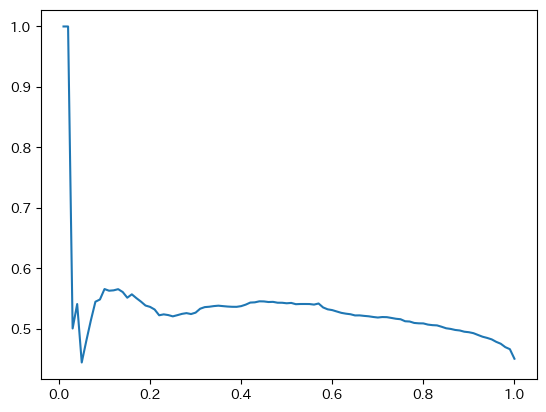

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(percent_points, ami)

In [111]:
diff_ami = np.gradient(ami)

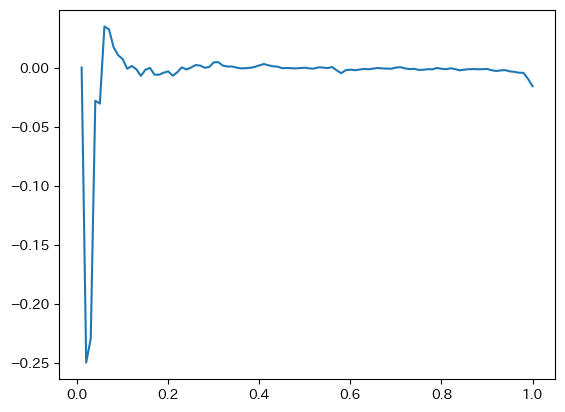

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(percent_points, diff_ami)

In [113]:
percent_point = 0.9

In [114]:
threshold = sp.stats.chi2(vector_dim).ppf(percent_point)
core_index = dist < threshold

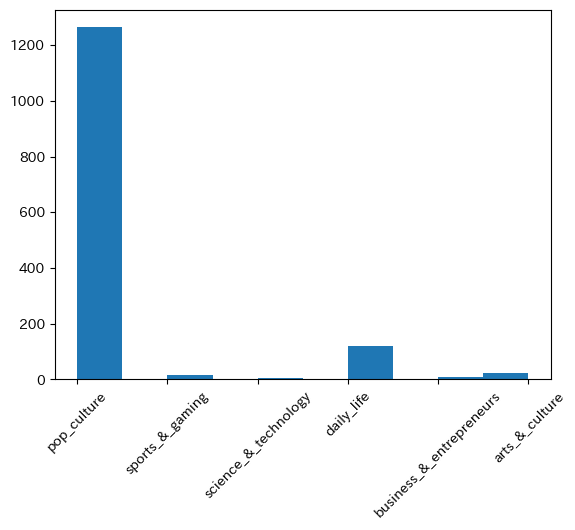

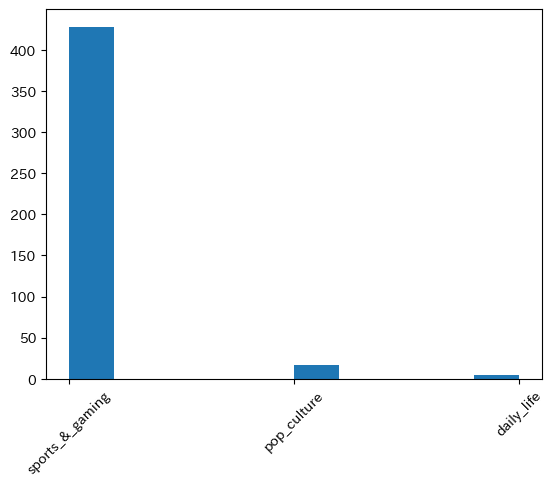

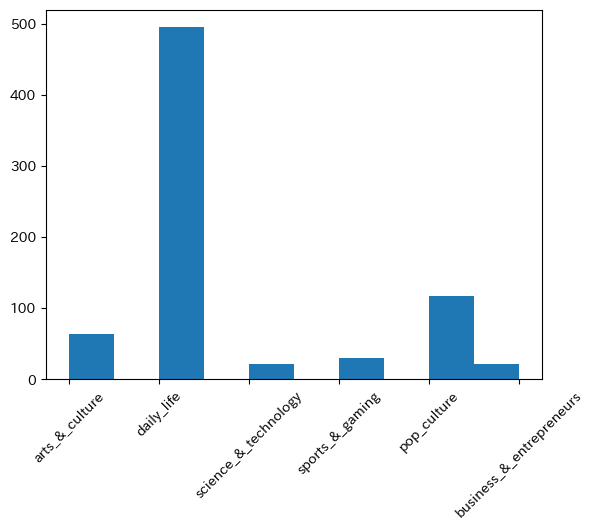

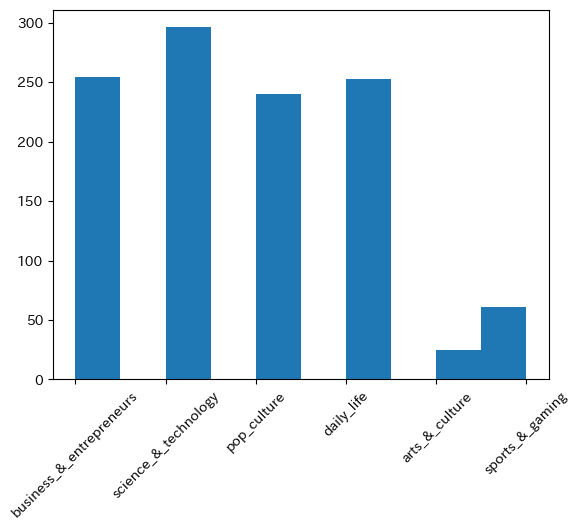

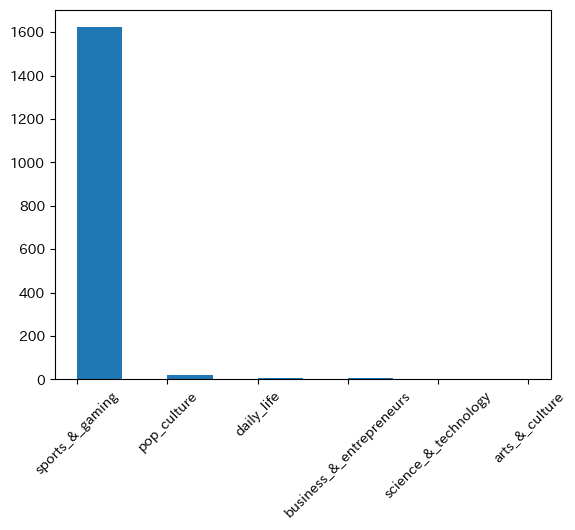

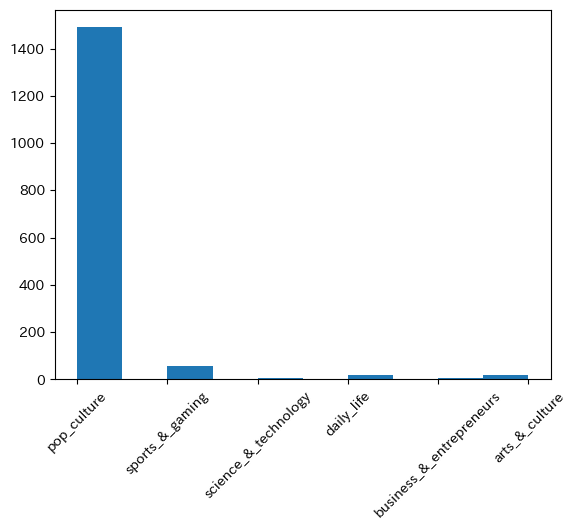

In [115]:
for cls in range(topic_num):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(x=df.loc[core_index[:, cls], "class"])
    plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'sports_&_gaming'),
  Text(1, 0, 'pop_culture'),
  Text(2, 0, 'arts_&_culture'),
  Text(3, 0, 'business_&_entrepreneurs'),
  Text(4, 0, 'science_&_technology'),
  Text(5, 0, 'daily_life')])

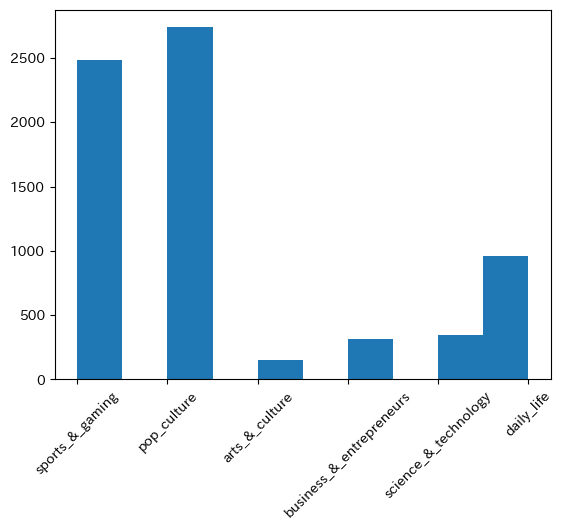

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=df.loc[:, "class"])
plt.xticks(rotation=45)